In [9]:
import numpy as np
import matplotlib.pyplot as plt
from lib import sig_gen
import tensorflow as tf
from tensorflow.keras import Input,layers
from numba import jit, njit, prange

print(tf.VERSION)
print(tf.keras.__version__)

ImportError: cannot import name 'Lambda'

In [2]:
@njit(parallel=True)
def sig_batch_gen(batch, symb, sps):
    """
    generate a signal batch
    no distortion yet
    """
    mibt = np.random.random((batch, 2))*0.8+0.3
    sig = np.empty((batch, symb*sps, 2))
    for idx in prange(batch):
        msg = np.random.randint(0, 2, symb)
        # generate oversampled signal
        sig_cpx = sig_gen.gfsk_mod(msg, sps*10, mibt[idx, 0], mibt[idx, 1])
        # apply timing offset
        sig_cpx = sig_cpx[np.random.randint(0, 10)::10]
        # parallel stuck if apply phase offset, move it to sig_gen
        # sig_cpx = sig_cpx*np.exp(1j*2*np.pi*np.random.random())
        sig[idx, :, 0] = sig_cpx.real
        sig[idx, :, 1] = sig_cpx.imag
    return sig, mibt

# sig, mibt = sig_batch_gen(batch, symb, sps)
# print(sig.shape, mibt.shape)
def train_generator(batch, symb, sps):
    while True:
        yield sig_batch_gen(batch, symb, sps)

        
batch = 1024
symb, sps = 64, 4
gen = train_generator(batch, symb, sps)
next(gen)[0].shape
# sig_batch_gen(batch, symb, sps)

(1024, 256, 2)

In [6]:

%timeit sig_batch_gen(batch, symb, sps)

6.44 ms ± 26.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [95]:
def build_model(input_shape):
    # build model
    model = tf.keras.Sequential()
    model.add(layers.Conv1D(16, 7, activation='relu',
                            input_shape=input_shape))
    model.add(layers.Conv1D(32, 7, activation='relu', strides=2))
    model.add(layers.Conv1D(32, 7, activation='relu', strides=2))
    model.add(layers.Conv1D(32, 7, activation='relu'))
#     model.add(layers.MaxPooling1D(2))
    model.add(layers.Flatten())
    model.add(layers.Dense(2))

    model.compile(optimizer='Adam',loss='mae')
    model.summary()

    return model


def build_model_icp(input_shape):
    # build model, not inception
    conv1 = layers.Conv1D(32, 7, activation='relu', strides=2)
    conv2 = layers.Conv1D(32, 7, activation='relu', strides=2)
    conv3 = layers.Conv1D(32, 7, activation='relu')
    
    input_tensor = Input(shape=input_shape)
    start_index = [0, 32, 64, 96, 128, 160, 192]
    slice_tensors = []
    for idx in start_index:
        slice_x = layers.Lambda(lambda x: x[:, idx:idx+64, :])(input_tensor)
        slice_x = conv1(slice_x)
        slice_x = conv2(slice_x)
        slice_x = conv3(slice_x)
        slice_tensors.append(slice_x)
    y = layers.Average()(slice_tensors)
        
#     x1 = layers.Lambda(lambda x: x[:, :64, :])(input_tensor)
#     x1 = conv1(x1)
#     x1 = conv2(x1)
#     x1 = conv3(x1)

#     x15 = layers.Lambda(lambda x: x[:, 32:96, :])(input_tensor)
#     x15 = conv1(x15)
#     x15 = conv2(x15)
#     x15 = conv3(x15)
    
#     x2 = layers.Lambda(lambda x: x[:, 64:128, :])(input_tensor)
#     x2 = conv1(x2)
#     x2 = conv2(x2)
#     x2 = conv3(x2)
    
#     x25 = layers.Lambda(lambda x: x[:, 96:160, :])(input_tensor)
#     x25 = conv1(x25)
#     x25 = conv2(x25)
#     x25 = conv3(x25)

#     x3 = layers.Lambda(lambda x: x[:, 128:192, :])(input_tensor)
#     x3 = conv1(x3)
#     x3 = conv2(x3)
#     x3 = conv3(x3)
    
#     x35 = layers.Lambda(lambda x: x[:, 160:224, :])(input_tensor)
#     x35 = conv1(x35)
#     x35 = conv2(x35)
#     x35 = conv3(x35)
    
#     x4 = layers.Lambda(lambda x: x[:, 192:, :])(input_tensor)
#     x4 = conv1(x4)
#     x4 = conv2(x4)
#     x4 = conv3(x4)
#     y = layers.Average()([x1, x15, x2, x25, x3, x35, x4])

    y = layers.Flatten()(y)
    y = layers.Dense(32, activation='relu')(y)
    output_tensor = layers.Dense(2)(y)

    model = tf.keras.Model(input_tensor, output_tensor)
    model.compile(optimizer='Adam',loss='mae')
    model.summary()

    return model


model = build_model_icp((symb*sps, 2))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_40 (InputLayer)           (None, 256, 2)       0                                            
__________________________________________________________________________________________________
lambda_116 (Lambda)             (None, 64, 2)        0           input_40[0][0]                   
__________________________________________________________________________________________________
lambda_117 (Lambda)             (None, 64, 2)        0           input_40[0][0]                   
__________________________________________________________________________________________________
lambda_118 (Lambda)             (None, 64, 2)        0           input_40[0][0]                   
__________________________________________________________________________________________________
lambda_119

In [80]:
# sanity check
x_test = np.random.rand(10, 256, 2)
model.predict(x_test).shape

(10, 2)

In [96]:
history = model.fit_generator(
    gen,
    steps_per_epoch=200,
    epochs=40
    )
model.save('mibt_est.h5')

Epoch 1/40
200/200 [==============================] - 6s 30ms/step - loss: 0.1345
Epoch 2/40
200/200 [==============================] - 4s 21ms/step - loss: 0.0868
Epoch 3/40
200/200 [==============================] - 4s 21ms/step - loss: 0.0809
Epoch 4/40
200/200 [==============================] - 4s 21ms/step - loss: 0.0786
Epoch 5/40
200/200 [==============================] - 4s 21ms/step - loss: 0.0750
Epoch 6/40
200/200 [==============================] - 4s 22ms/step - loss: 0.0684
Epoch 7/40
200/200 [==============================] - 4s 21ms/step - loss: 0.0632
Epoch 8/40
200/200 [==============================] - 4s 21ms/step - loss: 0.0577
Epoch 9/40
200/200 [==============================] - 4s 21ms/step - loss: 0.0502
Epoch 10/40
200/200 [==============================] - 4s 22ms/step - loss: 0.0466
Epoch 11/40
200/200 [==============================] - 4s 21ms/step - loss: 0.0460
Epoch 12/40
200/200 [==============================] - 4s 21ms/step - loss: 0.0436
Epoch 13/40
2

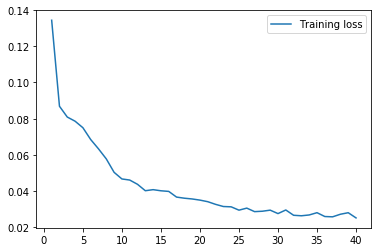

In [97]:
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, label='Training loss')
plt.legend()
plt.show()

In [98]:
batch = 1
symb, sps = 64, 4
x_test, target = sig_batch_gen(batch, symb, sps)
print(model.predict(x_test), target)


[[0.5261794  0.84673893]] [[0.53614587 0.8368762 ]]
